In [78]:
# import desired packages
import pandas as pd
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

In [79]:
# Access the Google Drive to load the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/03_10_Stock_Price_Prediction/DATASET/crwd_missing.csv')

In [81]:
# Print the columns of the dataframe
df.columns

Index(['Unnamed: 0', 'time stamp', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

In [82]:
# Get the desired columns in the dataframe
df = df[['time stamp', 'open', 'high', 'low', 'close', 'volume']]
df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', \
                                           'close']].round(decimals=4)
df['time stamp'] = pd.to_datetime(df['time stamp'])
df.head(10)

,time stamp,open,high,low,close,volume
0,2021-03-10 09:10:00,200.0900,200.0900,200.0000,200.0000,669
1,2021-03-10 09:11:00,200.1296,200.1296,200.0435,200.0435,646
2,2021-03-10 09:12:00,200.1691,200.1691,200.0870,200.0870,623
3,2021-03-10 09:13:00,200.2087,200.2087,200.1304,200.1304,600
4,2021-03-10 09:14:00,200.2483,200.2483,200.1739,200.1739,577
5,2021-03-10 09:15:00,200.2878,200.2878,200.2174,200.2174,554
6,2021-03-10 09:16:00,200.3274,200.3274,200.2609,200.2609,531
7,2021-03-10 09:17:00,200.3670,200.3670,200.3043,200.3043,508
8,2021-03-10 09:18:00,200.4065,200.4065,200.3478,200.3478,485
9,2021-03-10 09:19:00,200.4461,200.4461,200.3913,200.3913,462


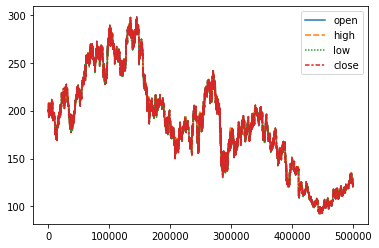

In [83]:
# Display the stock of open, high, low, close
sb.lineplot(data = df[['open', 'high', 'low', 'close']])
plt.show()

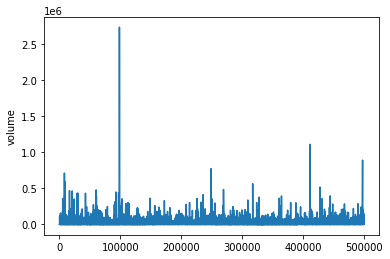

In [84]:
# Display the stock of volume
sb.lineplot(data = df['volume'])
plt.show()

In [85]:
# Show the statistics of the data
df.describe()

,open,high,low,close,volume
count,499641.000000,499641.000000,499641.000000,499641.000000,4.996410e+05
mean,186.805943,186.892915,186.710959,186.798759,4.538571e+03
std,50.563381,50.580899,50.551992,50.569566,1.246150e+04
min,92.344000,92.500000,92.250000,92.345000,-6.363000e+03
25%,153.160000,153.290000,153.061200,153.175000,3.000000e+02
50%,187.320000,187.425900,187.200000,187.300000,8.150000e+02
75%,220.010000,220.115000,219.940000,220.007500,4.716000e+03
max,297.870000,298.480000,297.010000,297.695000,2.739658e+06


In [86]:
# Split the dataframe into training and test dataset
df_train = df[0:int(len(df) * 0.6)]
df_val = df[int(len(df) * 0.6):int(len(df) * 0.8)]
df_test = df[int(len(df) * 0.8):-1]
print(len(df_train), len(df_val), len(df_test))

299784 99928 99928


In [87]:
# Print the tail of training, validation and test datasets
print(df_train.tail())
print(df_val.tail())
print(df_test.tail())

                time stamp      open      high       low     close  volume
299779 2022-06-03 20:14:00  162.1100  162.1100  162.1100  162.1100     340
299780 2022-06-03 20:15:00  162.1083  162.1083  162.1083  162.1083     673
299781 2022-06-03 20:16:00  162.1067  162.1067  162.1067  162.1067    1006
299782 2022-06-03 20:17:00  162.1050  162.1050  162.1050  162.1050    1339
299783 2022-06-03 20:18:00  162.1033  162.1033  162.1033  162.1033    1672
                time stamp      open      high       low   close  volume
399707 2022-11-15 17:03:00  149.2600  149.4800  149.1655  149.45    5616
399708 2022-11-15 17:04:00  149.5100  149.5500  149.4100  149.41    2931
399709 2022-11-15 17:05:00  149.4001  149.4433  149.1750  149.23    4910
399710 2022-11-15 17:06:00  149.2500  149.5550  149.2500  149.43    7435
399711 2022-11-15 17:07:00  149.5200  149.5450  149.3700  149.43    2767
                time stamp    open    high     low   close  volume
499635 2023-03-09 23:53:00  120.80  120.80  1

In [88]:
# Normalize the dataframe
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
intputFeatureList = ['open', 'high', 'low', 'close', 'volume']
training = scaler.fit_transform(df_train[intputFeatureList])
validation = scaler.transform(df_val[intputFeatureList])
test = scaler.transform(df_test[intputFeatureList])

In [89]:
print(training.shape, validation.shape, test.shape)

(299784, 5) (99928, 5) (99928, 5)


In [90]:
"""Define the function to create 
the input and output dataset for the training, validation and test"""
def create_dataset(transformed, df, prevMin, predMin):
    Xs, ys = [], []
    for i in range(len(transformed) - prevMin - predMin):
        vx = []
        for j in range(prevMin):
            vx.append(transformed[i + j])
        vy = []
        for j in range(predMin):
            vy.append(df['close'].iloc[i + j + prevMin])
        vx = np.array(vx)
        vy = np.array(vy)
        vx = vx.reshape(-1, 1)
        Xs.append(vx)
        ys.append(vy)
    return np.array(Xs), np.array(ys)

In [91]:
# Create the input and output of the models; prevMin=60m, predMin=15m
(prevMin, predMin) = (60, 15)
train_X, train_y = create_dataset(training, df_train, prevMin, predMin)
val_X, val_y = create_dataset(validation, df_val, prevMin, predMin)
test_X, test_y = create_dataset(test, df_test, prevMin, predMin)

In [92]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)

(299709, 300, 1) (299709, 15)
(99853, 300, 1) (99853, 15)
(99853, 300, 1) (99853, 15)


In [93]:
# Build the model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(train_X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=15))
model.compile(optimizer='adam', loss='MeanSquaredError', metrics=\
              ['mean_absolute_error'])

In [95]:
#Train the model
history = model.fit(train_X, train_y, epochs=30, batch_size=32, validation_data=(val_X, val_y))

Epoch 1/30
9366/9366 [==============================] - 233s 25ms/step - loss: 3.2209 - mean_absolute_error: 1.3722 - val_loss: 2.8373 - val_mean_absolute_error: 1.3743
Epoch 2/30
9366/9366 [==============================] - 223s 24ms/step - loss: 2.8117 - mean_absolute_error: 1.2852 - val_loss: 1.0742 - val_mean_absolute_error: 0.8352
Epoch 3/30
9366/9366 [==============================] - 239s 25ms/step - loss: 2.6776 - mean_absolute_error: 1.2532 - val_loss: 2.6739 - val_mean_absolute_error: 1.4883
Epoch 4/30
9366/9366 [==============================] - 238s 25ms/step - loss: 2.5067 - mean_absolute_error: 1.2120 - val_loss: 0.6631 - val_mean_absolute_error: 0.5666
Epoch 5/30
9366/9366 [==============================] - 224s 24ms/step - loss: 2.4166 - mean_absolute_error: 1.1903 - val_loss: 1.0489 - val_mean_absolute_error: 0.8470
Epoch 6/30
9366/9366 [==============================] - 222s 24ms/step - loss: 2.3508 - mean_absolute_error: 1.1724 - val_loss: 0.7164 - val_mean_absolute_

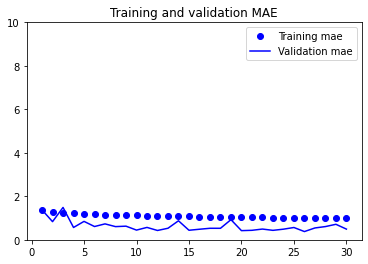

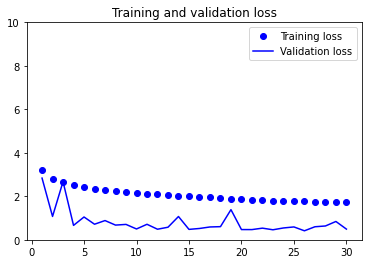

In [96]:
# Calculate the metrices and display the training and validation results
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)
plt.ylim([0, 10])
plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation MAE')
plt.legend()
plt.figure()
plt.ylim([0, 10])
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [97]:
# Evaluate the model; Evaluation metric-Mean Absolute Error
test_loss, test_mae = model.evaluate(test_X, test_y)
print(test_loss, test_mae)

3121/3121 [==============================] - 30s 10ms/step - loss: 21.1649 - mean_absolute_error: 3.5798
21.164867401123047 3.5797550678253174


In [98]:
# Save the model
model.save('/content/drive/MyDrive/03_10_Stock_Price_Prediction/Saved Models/demo_train_model.h5')

In [99]:
# Predict the model of the test dataset
pred = model.predict(test_X).round(4)

3121/3121 [==============================] - 27s 8ms/step


In [100]:
pred.shape

(99853, 15)

In [101]:
# Create a dataframe to show the output of the prediction
realLabelList = []
testLabelList = []
for i in range(15):
  realLabelList.append('real' + str(i + 1))
  testLabelList.append('pred' + str(i + 1))

df_test_show = pd.DataFrame(columns = [['time stamp'] + realLabelList + testLabelList])
for i in range(len(df_test) - prevMin - predMin):
  df_test_show.loc[i] = [df_test['time stamp'].iloc[prevMin + i]] + test_y[i].tolist() + pred[i].tolist()
df_test_show[testLabelList] = df_test_show[testLabelList].round(4)

In [102]:
# Result of the prediction of first 1 min
df_test_show[['time stamp', 'real1', 'pred1']].loc[:10]

,time stamp,real1,pred1
0,2022-11-15 18:08:00,149.65,149.0415
1,2022-11-15 18:09:00,149.14,149.0653
2,2022-11-15 18:10:00,148.88,148.9488
3,2022-11-15 18:11:00,149.00,148.5471
4,2022-11-15 18:12:00,148.94,148.5790
5,2022-11-15 18:13:00,149.01,148.5368
6,2022-11-15 18:14:00,149.20,148.6066
7,2022-11-15 18:15:00,148.88,148.6710
8,2022-11-15 18:16:00,148.92,148.5752
9,2022-11-15 18:17:00,148.84,148.4512


In [103]:
# Save the predicted result and the correct data into csv file
df_test_show.to_csv('/content/drive/MyDrive/03_10_Stock_Price_Prediction/RESULT/result_compare.csv')

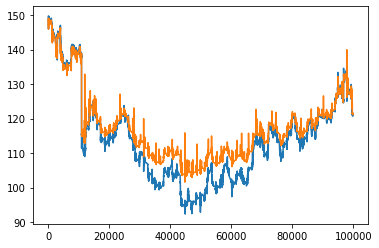

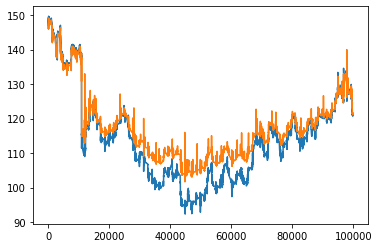

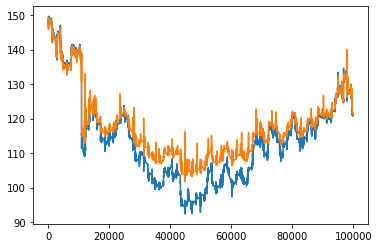

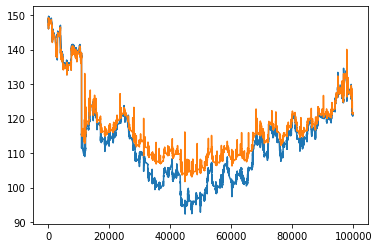

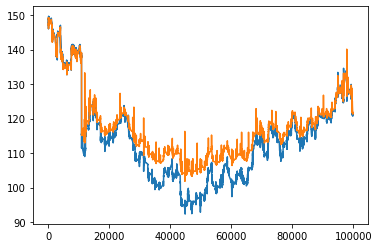

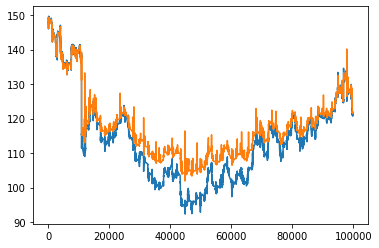

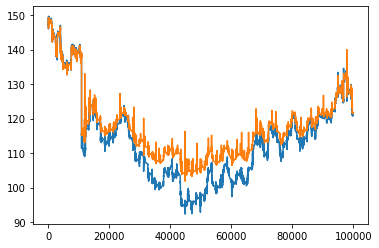

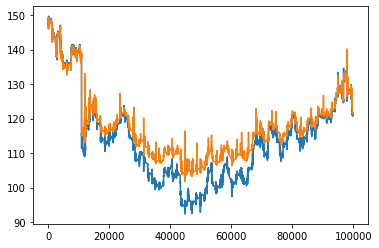

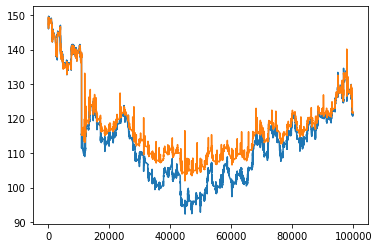

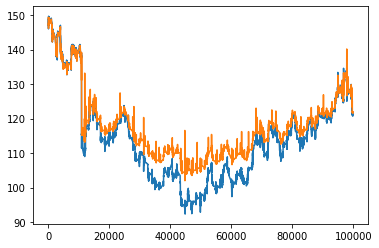

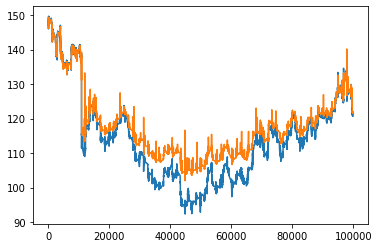

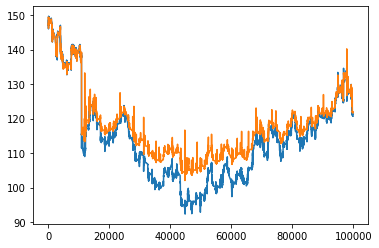

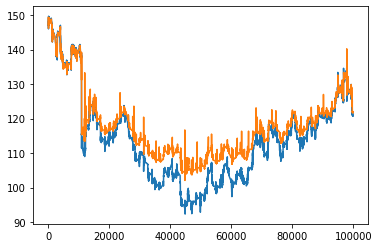

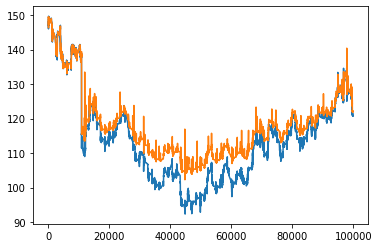

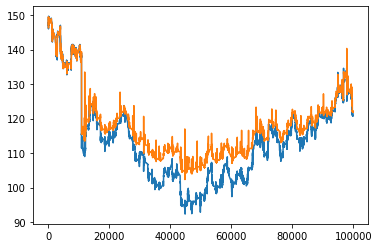

In [107]:
# Visualize the 
for i in range(15):
  plt.figure()
  plt.plot(df_test_show['real' + str(i + 1)])
  plt.plot(df_test_show['pred' + str(i + 1)])